In [3]:
from scipy.misc import comb
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

### 集成分类器出错率的概率密度函数

In [4]:
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/2.0)
    probs = [comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k) for k in range(int(k_start),n_classifier+1)]
    return sum(probs)

In [5]:
ensemble_error(11,0.25)

0.034327507019042969

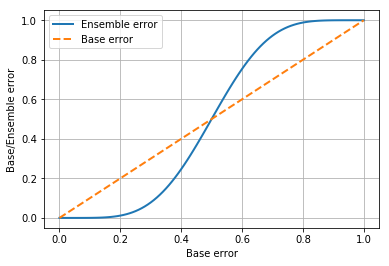

In [10]:
#画出成员分类器的出错率与集成分类器出错率之间的关系
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

从图中看到，当成员分类器的出错率低于随机猜测时(二分类的情况)，即$\epsilon <0.5$,集成分类器的出错率要低于单个分类器。 

## 多数投票分类器

In [2]:
#基于类别预测概率的加权多数投票算法
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    '''A majority vote ensemble classifier
    Parameters
    ---------------
    classifiers: array-like, shape=[n_classifiers]
        Different classifiers for the ensemble
        
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
            If 'classlabel' the prediction is based on
            the argmax of class labels. Else if
            'probability', the argmax of the sum of
            probabilities is used to predict the class label
            (recommended for calibrated classifiers).
            
    weights: array-like, shape=[n_classifiers]
        Optional, default: None
            If a list of `int` or `float` values are
            provided, the classifiers are weighted by 
            importance; Uses uniform weights if `weights=None`.
    '''
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        #这个是什么
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        '''Fit classifiers.
        Parameters
        --------------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape=[n_samples]
            Vector of target class labels.
            
        Returns
        --------------
        self: object
        '''
        #Use LabelEncoder to ensure class labels start
        #with 0, which is important for np.argmax
        #call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
        
    def predict(self, X):
        '''Predict class labels for X.
        
        Parameters
        ---------------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
            
        Returns
        ---------------
        maj_vote : array-like, shape=[n_samples]
            Predicted class labels.
            
        '''
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else: #'classlabel' vote
            #Collect results form clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                     for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    #返回平均概率
    def predict_proba(self, X):
        '''Predict class probabilities for X.
        
        Parameters
        ---------------
        X : {array-like, Sparse matrix},
            shape=[n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
        Returns
        ----------------
        avg_proba: array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        '''
        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        '''Get classifier parameter names for GridSearch'''
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
            

多数分类器说明：使用两个基类BaseEstimator和ClassifierMixin获取某些基本方法（set_params，get_params，score方法均来自这些基类）。导入six包从而使得MajorityVoteClassifier与Python2.7兼容。
predict_proba方法来返回平均概率，这在计算AUC时需要用到。
通过get_params方法来获取集成分类器中独立成员函数的参数。

In [4]:
#读取数据集对多数分类器进行测试
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)